In [1]:
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
import childespy
import numpy as np
import os
import imp
import pandas as pd
import transformers
import torch
import re
import unicodedata
import scipy.stats
import copy
from string import punctuation

In [2]:
from utils_model_sampling import sample_models_across_time
from utils import load_models

In [3]:
# 7/2/21: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2
# end cite

In [4]:
# Is it possible that it has memory issues?
# Make is_subset -> False after development is complete.

raw_scores_across_time = pd.concat(sample_models_across_time.assemble_scores_no_order())


/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_1.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_4.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/all/all/Adult_BERT_without_tags,_,_same_utt_only/r

/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/young/CHILDES_BERT_without_tags,_younger_children,_+-20_utts_context/run_models_across_time_1.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/young/CHILDES_BERT_without_tags,_younger_children,_+-20_utts_context/run_models_across_time_4.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/young/CHILDES_BERT_without_tags,_younger_children,_+-20_utts_context/run_models_across_time_2.0.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listening/experiments/no_versioning/scores/n=500/val/age/young/CHILDES_BERT_without_tags,_younger_children,_+-20_utts_context/run_models_across_time_0.5.pkl
/home/nwong/chompsky/childes/child_listening_continuation/child-directed-listeni

In [5]:
# Possibly too complex to generate the betas in the title automatically
# -- for now, just display the betas in the notebook separately.

from utils_model_sampling import beta_utils
from pprint import pprint

all_args = load_models.gen_shelf_model_args() #load_models.gen_all_model_args()

beta_set = {}
for arg_set in all_args:
    model_title = load_models.gen_model_title(*arg_set)
    this_beta = beta_utils.get_optimal_beta_value(*arg_set)
    
    beta_set[model_title] = round(this_beta, 3)
    
pprint(beta_set)

{'Adult BERT without tags, , +-20 utts context': 3.3,
 'Adult BERT without tags, , same utt only': 3.4,
 'CHILDES unigram without tags, , same utt only': 2.5,
 'Flat prior without tags, , same utt only': 2.5}


In [6]:
# From the original analysis

original_set_of_models = {
    'CHILDES BERT without tags, , +-20 utts context',
    'CHILDES BERT without tags, , same utt only',
    'Adult BERT without tags, , +-20 utts context',
    'Adult BERT without tags, , same utt only',
    'CHILDES Unigram',
    'Flat Unigram',
}

# Remove the all/all/20/with_tags! It's not updated.
set_of_models_that_works = {'Adult BERT without tags, , +-20 utts context',
 'Adult BERT without tags, , same utt only',
 'CHILDES BERT with tags, , same utt only',
 'CHILDES BERT with tags, older children, +-20 utts context',
 'CHILDES BERT with tags, older children, same utt only',
 'CHILDES BERT with tags, younger children, +-20 utts context',
 'CHILDES BERT with tags, younger children, same utt only',
 'CHILDES BERT without tags, , +-20 utts context',
 'CHILDES BERT without tags, , same utt only',
 'CHILDES BERT without tags, older children, +-20 utts context',
 'CHILDES BERT without tags, older children, same utt only',
 'CHILDES BERT without tags, younger children, +-20 utts context',
 'CHILDES BERT without tags, younger children, same utt only',
 'CHILDES Unigram',
 'Flat Unigram'}

is_filter = False #True
if is_filter:
    # I think if you don't copy R will get the slice and still try to compute over all models
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(original_set_of_models)].copy()
else:
    scores_across_time = raw_scores_across_time[raw_scores_across_time.model.isin(set_of_models_that_works)]

In [7]:
scores_across_time['token'] = scores_across_time['token'].astype(str)
scores_across_time_short = scores_across_time[['posterior_surprisal','posterior_entropy','prior_surprisal',
    'kl_flat_to_prior', 'kl_flat_to_posterior', 'model','set','age','token','bert_token_id', 'edit_distance']]
%R -i scores_across_time_short

/home/nwong/chompsky/childes/child_listening_continuation/child-listening-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
%%R
library('plyr')
# rename the models

# Do this manually for now.

model_levels = c("CHILDES BERT with tags, , +-20 utts context",
                 'CHILDES BERT without tags, , +-20 utts context',
                 "CHILDES BERT with tags, , same utt only",
                 "CHILDES BERT without tags, , same utt only",
                 "Adult BERT with tags, , +-20 utts context",
                 "Adult BERT without tags, , +-20 utts context",
                 "Adult BERT with tags, , same utt only",
                 "Adult BERT without tags, , same utt only",
                 "CHILDES BERT with tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, +-20 utts context",
                 "CHILDES BERT without tags, older children, same utt only",
                 "CHILDES BERT with tags, older children, same utt only",
                 "CHILDES BERT with tags, younger children, +-20 utts context",
                 "CHILDES BERT without tags, younger children, +-20 utts context",
                 "CHILDES BERT with tags, younger children, same utt only",
                 "CHILDES BERT without tags, younger children, same utt only",
                 "CHILDES Unigram",
                 "Flat Unigram"
)

model_new_levels = c("CHILDES BERT with tags, , +-20 utts context" = "CDL+Context+Tags",
                    "CHILDES BERT without tags, , +-20 utts context" = "CDL+Context",
                    "CHILDES BERT with tags, , same utt only" = "CDL+OneUtt+Tags",
                    "CHILDES BERT without tags, , same utt only" = "CDL+OneUtt", 
                    "Adult BERT with tags, , +-20 utts context" = "BERT+Context+Tags",
                    "Adult BERT without tags, , +-20 utts context" = "BERT+Context",
                    "Adult BERT with tags, , same utt only" = "BERT+OneUtt+Tags",
                    "Adult BERT without tags, , same utt only" = "BERT+OneUtt",
                    "CHILDES BERT with tags, older children, +-20 utts context" = "CDL+Older+Context+Tags",
                    "CHILDES BERT without tags, older children, +-20 utts context" = "CDL+Older+Context",
                    "CHILDES BERT with tags, older children, same utt only" = "CDL+Older+OneUtt+Tags",
                    "CHILDES BERT without tags, older children, same utt only" = "CDL+Older+OneUtt",
                    "CHILDES BERT with tags, younger children, +-20 utts context" = "CDL+Younger+Context+Tags",
                    "CHILDES BERT without tags, younger children, +-20 utts context" = "CDL+Younger+Context",
                    "CHILDES BERT with tags, younger children, same utt only" = "CDL+Younger+OneUtt+Tags", 
                    "CHILDES BERT without tags, younger children, same utt only" = "CDL+Younger+OneUtt",
                    "CHILDES Unigram" = "CHILDES 1gram",
                    "Flat Unigram" = "UniformPrior"
)


scores_across_time_short$model = factor(scores_across_time_short$model, model_levels)
scores_across_time_short$model = revalue(scores_across_time_short$model, model_new_levels)

successes_across_time = subset(scores_across_time_short, set == 'success')

# 10 Average Prior Surprisal

In [9]:
%%R
names(successes_across_time)

aggregate(prior_surprisal ~ model, successes_across_time, function(x){mean(-1 * log(x, 2))})

                      model prior_surprisal
1               CDL+Context        3.424069
2           CDL+OneUtt+Tags        4.990364
3                CDL+OneUtt        5.110510
4              BERT+Context        4.742134
5               BERT+OneUtt        7.286162
6    CDL+Older+Context+Tags        3.388120
7         CDL+Older+Context        3.502749
8          CDL+Older+OneUtt        5.336271
9     CDL+Older+OneUtt+Tags        5.069460
10 CDL+Younger+Context+Tags        3.487031
11      CDL+Younger+Context        3.512024
12  CDL+Younger+OneUtt+Tags        5.185012
13       CDL+Younger+OneUtt        5.234265
14            CHILDES 1gram       18.297190
15             UniformPrior       12.948367


In [10]:
%%R

# 7/15/21 not a code reference, but debugging help:
# https://stackoverflow.com/questions/60083062/tidyrspread-error-each-row-of-output-must-be-identified-by-a-unique-combina
# https://community.rstudio.com/t/spread-error-each-row-of-output-must-be-identified-by-a-unique-combination-of-keys/88325
# https://garrettgman.github.io/tidying

library('tidyr')
successes_across_time_wide =  spread(successes_across_time[,c('model','prior_surprisal',
'bert_token_id')], model, prior_surprisal)

head(successes_across_time_wide)

  bert_token_id  CDL+Context CDL+OneUtt+Tags   CDL+OneUtt BERT+Context
1         49676 0.0007204352     0.001790194 0.0019628888 1.374463e-05
2         52857 0.0256987140     0.001949325 0.0015860118 3.800371e-03
3         60498 0.0025232614     0.001306169 0.0042884611 5.194001e-02
4         60499 0.0008698311     0.000208751 0.0001290685 3.491802e-06
5         65634 0.1811656952     0.085646421 0.0711195245 3.223022e-01
6         65852 0.0445239507     0.085646421 0.0711195245 4.058891e-02
   BERT+OneUtt CDL+Older+Context+Tags CDL+Older+Context CDL+Older+OneUtt
1 5.328564e-05           0.0004065618      1.806228e-04     8.186627e-04
2 2.886749e-04           0.0046467707      1.144458e-02     7.121616e-04
3 2.543838e-02           0.0134188002      3.004536e-03     4.521226e-03
4 4.082376e-05           0.0002857940      2.468799e-05     6.390866e-05
5 1.886122e-02           0.2467705309      2.004428e-01     3.028459e-02
6 1.886122e-02           0.0570895337      2.411982e-02     3.028

In [11]:
%%R
model_names = unique(successes_across_time$model)
print(model_names) # Probably because it's not a copy?

# It's still 18 levels -- why?

 [1] BERT+OneUtt              BERT+Context             CDL+OneUtt+Tags         
 [4] CDL+OneUtt               CDL+Context              CDL+Younger+OneUtt+Tags 
 [7] CDL+Younger+Context+Tags CDL+Younger+OneUtt       CDL+Younger+Context     
[10] CDL+Older+OneUtt+Tags    CDL+Older+Context+Tags   CDL+Older+OneUtt        
[13] CDL+Older+Context        UniformPrior             CHILDES 1gram           
18 Levels: CDL+Context+Tags CDL+Context CDL+OneUtt+Tags ... UniformPrior


In [12]:
%%R
#Pairwise paired t-test between all of the models

model_names = unique(successes_across_time$model) 

rvs = mat.or.vec(length(model_names), length(model_names))

for (model_idx in c(1:length(model_names))){
    for (comparison_model_idx in c(1:length(model_names))){
        if (model_idx == comparison_model_idx){
            rvs[model_idx, comparison_model_idx] = NA
        } else {
            model_name = model_names[model_idx]
            comparison_model_name = model_names[comparison_model_idx]
            rvs[model_idx, comparison_model_idx] = t.test(
                successes_across_time_wide[[model_name]], 
                successes_across_time_wide[[comparison_model_name]],
              paired=T)$p.value
        }
    }
}
rvs = data.frame(rvs)

rownames(rvs) = model_names
colnames(rvs) = model_names

rvs

R[write to console]: Error in .subset2(x, i, exact = exact) : subscript out of bounds




Error in .subset2(x, i, exact = exact) : subscript out of bounds


### Posterior Surprisal Across Ages

## Note to self: Check correctness of young/old divide len stdev here -- possibly ask about this; Is probably adaptive?

In [13]:
%R sem <- function(x) sd(x)/sqrt(length(x))
%R mean_surprisal_by_age = aggregate(posterior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x))})
%R names(mean_surprisal_by_age) = c('age','model','posterior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(posterior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age_sem) = c('age','model','posterior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 
%R print(mean_surprisal_by_age)

    age                    model posterior_surprisal_mean
1   0.5             BERT+Context                1.1616040
2   0.5              BERT+OneUtt                6.9326822
3   0.5              CDL+Context                1.5797801
4   0.5        CDL+Older+Context                0.2270885
5   0.5   CDL+Older+Context+Tags                0.4272493
6   0.5         CDL+Older+OneUtt                5.6343270
7   0.5    CDL+Older+OneUtt+Tags                5.2932224
8   0.5               CDL+OneUtt                4.9265283
9   0.5          CDL+OneUtt+Tags                4.1969518
10  0.5      CDL+Younger+Context                0.0696115
11  0.5 CDL+Younger+Context+Tags                0.2903472
12  0.5       CDL+Younger+OneUtt                4.4135313
13  0.5  CDL+Younger+OneUtt+Tags                4.5323737
14  0.5            CHILDES 1gram               10.5442954
15  0.5             UniformPrior                4.7391750
16  1.5             BERT+Context                1.8317764
17  1.5       

41               0.14299055
42               0.20211065
43               0.20918119
44               0.22477601
45               0.15550190
46               0.08165165
47               0.10830676
48               0.07219783
49               0.07604268
50               0.07543826
51               0.09296475
52               0.09273837
53               0.08738298
54               0.08562368
55               0.07354148
56               0.07299158
57               0.08722109
58               0.08770065
59               0.16237117
60               0.08736454
61               0.10282370
62               0.12792992
63               0.07698785
64               0.08402998
65               0.08223248
66               0.10970791
67               0.10772349
68               0.10407967
69               0.10488200
70               0.08040165
71               0.08227893
72               0.10339854
73               0.10759054
74               0.19583367
75               0.10052029
76               0.0

,age,model,posterior_surprisal_mean,posterior_surprisal_sem
1,0.5,BERT+Context,1.161604,NaN
2,0.5,BERT+OneUtt,6.932682,NaN
3,0.5,CDL+Context,1.579780,NaN
4,0.5,CDL+Older+Context,0.227089,NaN
5,0.5,CDL+Older+Context+Tags,0.427249,NaN
...,...,...,...,...
116,4.0,CDL+Younger+Context+Tags,0.674351,0.071221
117,4.0,CDL+Younger+OneUtt,0.882220,0.084394
118,4.0,CDL+Younger+OneUtt+Tags,0.893440,0.086324
119,4.0,CHILDES 1gram,6.619958,0.186640


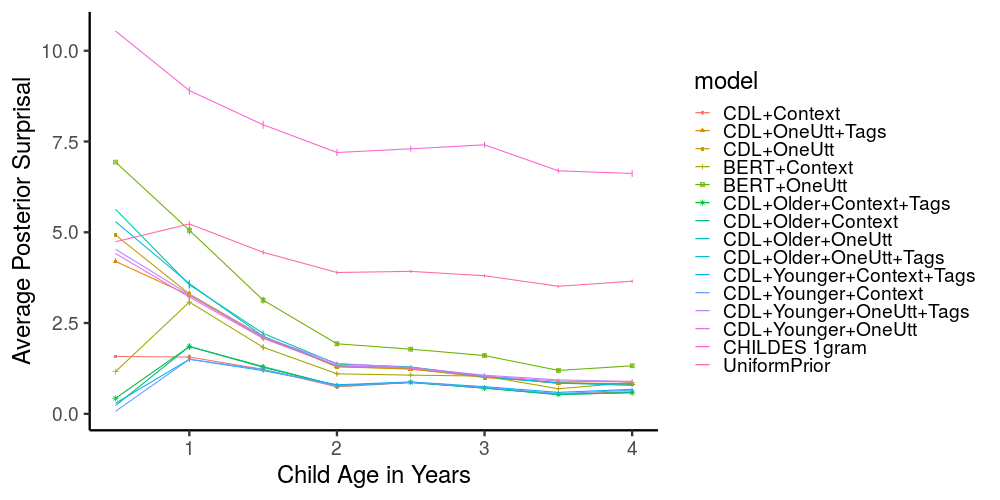

In [14]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_point(aes(x=age, y=posterior_surprisal_mean, color=model,
shape = model)) + geom_line(aes(x=age, y=posterior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=posterior_surprisal_mean - .5*posterior_surprisal_sem, 
ymax=posterior_surprisal_mean + .5*posterior_surprisal_sem, color=model ), width=0) + theme_classic(
base_size = 24) + ylab('Average Posterior Surprisal') + xlab('Child Age in Years')

### Prior Surprisal Across Ages

In [15]:
## scores_across_time = pd.concat(score_store)
%R mean_surprisal_by_age = aggregate(prior_surprisal ~ age + model, successes_across_time ,\
                function(x){mean(-1 * log(x, base =2))})
%R names(mean_surprisal_by_age) = c('age','model','prior_surprisal_mean')
%R mean_surprisal_by_age_sem = aggregate(prior_surprisal ~ age + model, \
        successes_across_time, function(x){sem(-1 * log(x))})
%R names(mean_surprisal_by_age_sem) = c('age','model','prior_surprisal_sem')
%R mean_surprisal_by_age = merge(mean_surprisal_by_age, mean_surprisal_by_age_sem) 

,age,model,prior_surprisal_mean,prior_surprisal_sem
1,0.5,BERT+Context,6.080170,NaN
2,0.5,BERT+OneUtt,12.859728,NaN
3,0.5,CDL+Context,8.021802,NaN
4,0.5,CDL+Older+Context,2.001964,NaN
5,0.5,CDL+Older+Context+Tags,2.185042,NaN
...,...,...,...,...
116,4.0,CDL+Younger+Context+Tags,3.481106,0.093076
117,4.0,CDL+Younger+OneUtt,4.635928,0.101650
118,4.0,CDL+Younger+OneUtt+Tags,4.558487,0.101561
119,4.0,CHILDES 1gram,17.719039,0.112118


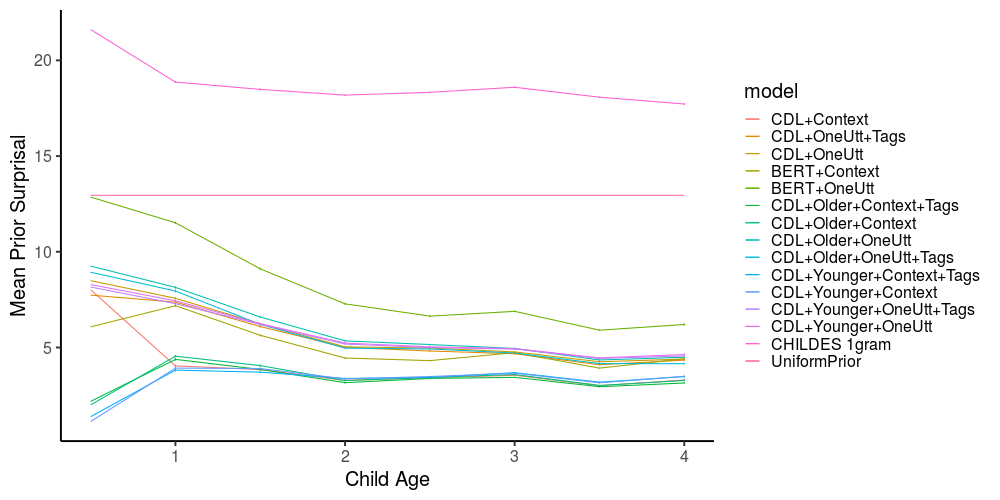

In [16]:
%%R -w 1000 -h 500
ggplot(mean_surprisal_by_age) + geom_line(aes(x=age, y=prior_surprisal_mean, color=model)
) + geom_errorbar(aes(x=age, ymin=prior_surprisal_mean - .5*prior_surprisal_sem, 
ymax=prior_surprisal_mean + .5*prior_surprisal_sem , color=model), width=0) + theme_classic(
base_size=20) + ylab('Mean Prior Surprisal') + xlab('Child Age')

In [17]:
scores_across_time_short.set.value_counts()

success    123510
failure     38955
Name: set, dtype: int64

### Posterior Entropy Stratified by Successes vs. Failures

In [18]:
%R posterior_entropy_by_age = aggregate(posterior_entropy ~ age + model + set, scores_across_time_short ,\
                function(x){mean(x)})
%R names(posterior_entropy_by_age) = c('age','model', 'set', 'posterior_entropy_mean')
%R posterior_entropy_by_age_sem = aggregate(posterior_entropy ~ age + model + set, \
        scores_across_time_short, sem)
%R names(posterior_entropy_by_age_sem) = c('age','model','set','posterior_entropy_sem')
%R posterior_entropy_by_age = merge(posterior_entropy_by_age, posterior_entropy_by_age_sem) 
%R posterior_entropy_by_age

,age,model,set,posterior_entropy_mean,posterior_entropy_sem
1,0.5,BERT+Context,failure,1.315164,NaN
2,0.5,BERT+Context,success,2.230109,NaN
3,0.5,BERT+OneUtt,failure,1.577705,NaN
4,0.5,BERT+OneUtt,success,1.577705,NaN
5,0.5,CDL+Context,failure,0.548938,NaN
...,...,...,...,...,...
236,4.0,CDL+Younger+OneUtt+Tags,success,0.851727,0.033858
237,4.0,CHILDES 1gram,failure,3.964596,0.251652
238,4.0,CHILDES 1gram,success,3.683562,0.027170
239,4.0,UniformPrior,failure,6.185869,0.133486


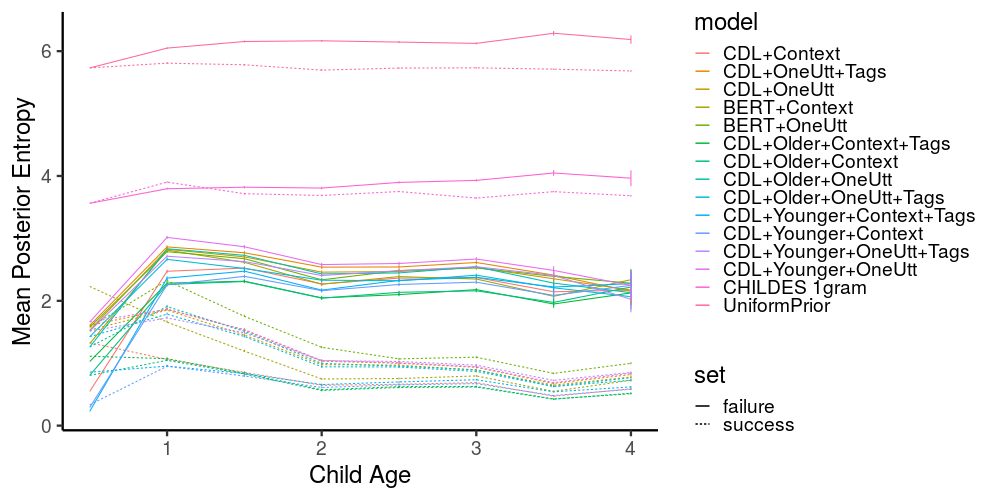

In [19]:
%%R -w 1000 -h 500
ggplot(posterior_entropy_by_age) + geom_line(aes(x=age, y=posterior_entropy_mean, color=model, linetype=set)
) + geom_errorbar(aes(x=age, ymin=posterior_entropy_mean - .5*posterior_entropy_sem, 
ymax=posterior_entropy_mean + .5*posterior_entropy_sem, color=model, linetype=set ), width=0) + theme_classic(
base_size=24) + ylab('Mean Posterior Entropy') + xlab('Child Age')

# 11 Information Gain 

In [20]:
%%R
# adjust the base from log to 2 in successes_across_time
successes_across_time$kl_flat_to_prior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_prior), base=2)
successes_across_time$kl_flat_to_posterior = -1 * log (exp(-1 * 
    successes_across_time$kl_flat_to_posterior), base=2)

In [21]:
%%R
mean_kl_flat_to_prior_by_age = aggregate(kl_flat_to_prior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_prior_by_age) = c('age','model','kl_flat_to_prior')
mean_kl_flat_to_prior_by_age_sem = aggregate(kl_flat_to_prior ~ age + model,
        successes_across_time, sem)
names(mean_kl_flat_to_prior_by_age_sem) = c('age','model','kl_flat_to_prior_sem')
mean_kl_flat_to_prior_by_age = merge(mean_kl_flat_to_prior_by_age, mean_kl_flat_to_prior_by_age_sem) 


mean_kl_flat_to_posterior_by_age = aggregate(kl_flat_to_posterior ~ age + model, successes_across_time, mean)
names(mean_kl_flat_to_posterior_by_age) = c('age','model','kl_flat_to_posterior')
mean_kl_flat_to_posterior_by_age_sem = aggregate(kl_flat_to_posterior ~ age + model, 
        successes_across_time, sem)
names(mean_kl_flat_to_posterior_by_age_sem) = c('age','model','kl_flat_to_posterior_sem')
mean_kl_flat_to_posterior_by_age = merge(mean_kl_flat_to_posterior_by_age, 
    mean_kl_flat_to_posterior_by_age_sem) 

names(mean_kl_flat_to_posterior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_posterior_by_age$comparison = 'posterior'

names(mean_kl_flat_to_prior_by_age) = c('age','model','gain','gain_sem' )
mean_kl_flat_to_prior_by_age$comparison =  'fitted prior'

kls = rbind.fill(mean_kl_flat_to_posterior_by_age, mean_kl_flat_to_prior_by_age)
kls$age_in_months = kls$age * 12
head(kls)

  age                  model     gain gain_sem comparison age_in_months
1 0.5           BERT+Context 16.73870       NA  posterior             6
2 0.5            BERT+OneUtt 16.63872       NA  posterior             6
3 0.5            CDL+Context 18.63246       NA  posterior             6
4 0.5      CDL+Older+Context 22.77205       NA  posterior             6
5 0.5 CDL+Older+Context+Tags 21.76418       NA  posterior             6
6 0.5       CDL+Older+OneUtt 17.90360       NA  posterior             6


In [22]:
%%R
subset(kls, comparison =='posterior' & model == 'UniformPrior')

    age        model     gain   gain_sem comparison age_in_months
15  0.5 UniformPrior 6.033721         NA  posterior             6
30  1.5 UniformPrior 5.584792 0.03672279  posterior            18
45  1.0 UniformPrior 5.390278 0.03803818  posterior            12
60  2.5 UniformPrior 5.767324 0.02815050  posterior            30
75  2.0 UniformPrior 5.686460 0.03116785  posterior            24
90  3.5 UniformPrior 5.746066 0.02624322  posterior            42
105 3.0 UniformPrior 5.774997 0.03031776  posterior            36
120 4.0 UniformPrior 5.878937 0.03402155  posterior            48


In [23]:
%%R
# how to get the unigrams on every line
unigram_posterior = subset(kls, comparison =='posterior' & model == 'UniformPrior')
unigram_posterior['comparison'] = 'perceptual data'

excluding_unigram = subset(kls, model != 'UniformPrior')
by_model = split(excluding_unigram, as.character(excluding_unigram$model))
kls_with_uniform_prior = do.call('rbind', lapply(by_model, function(one_model){
        # merge by age in months
        unigram_posterior['model'] = one_model$model[1]
        return(rbind(one_model, unigram_posterior))    
})) 

In [24]:
%%R
kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'fitted prior'] = "context (fitted prior)"

kls_with_uniform_prior$comparison[kls_with_uniform_prior$
    comparison == 'posterior'] = "perceptual data & context\n(posterior)"

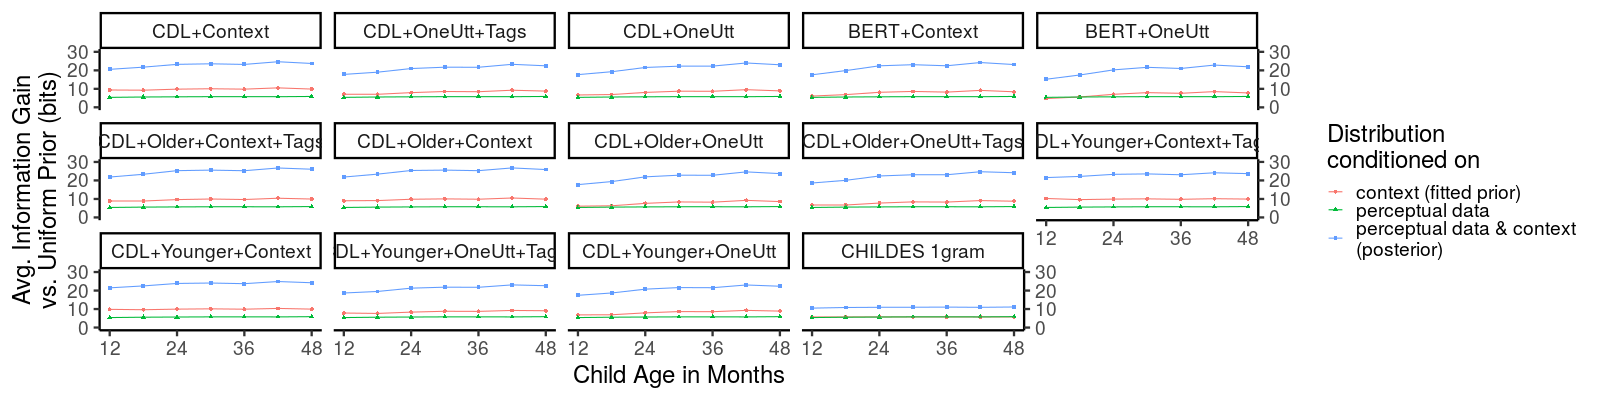

In [25]:
%%R -w 1600 -h 400
child_age_ticks = c(12,24,36,48) 
p1 = ggplot(subset(kls_with_uniform_prior, age_in_months > 6)) + geom_point(aes(x=age_in_months, 
y= gain, color=comparison,  shape=comparison)
) + facet_wrap(~model, ncol=5) + geom_line(aes(x=age_in_months, y= gain, color=comparison, 
shape=comparison)) + theme_classic(base_size=24) + coord_cartesian(ylim = c(0,30)
) + xlab('Child Age in Months') + ylab('Avg. Information Gain\nvs. Uniform Prior (bits)'
) + scale_y_continuous(sec.axis = sec_axis( trans=~.)
) + scale_color_discrete(name = "Distribution\nconditioned on") + scale_shape_discrete(
name = "Distribution\nconditioned on") + scale_x_continuous( breaks = child_age_ticks, 
labels = child_age_ticks)
ggsave('figures/information_gain_2.pdf', width=16, height=4)
print(p1)

# 12 Posterior Probability as a function of edit distance

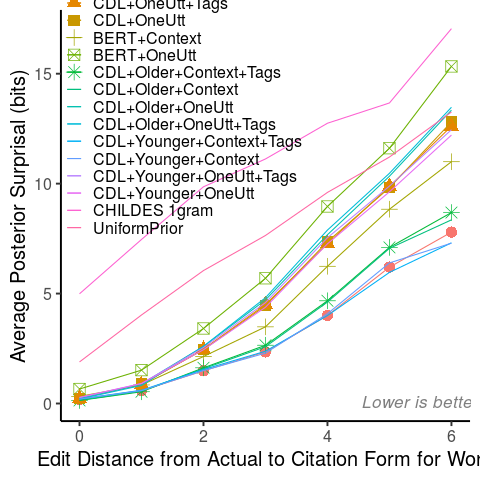

In [26]:
%%R
surprisal_by_edit_distance = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){mean(-1 * log(x))})
names(surprisal_by_edit_distance) = c('edit_distance', 'model', 'mean_posterior_surprisal')
sem <- function(x) sd(x)/sqrt(length(x))
surprisal_by_edit_distance_sem = aggregate(posterior_surprisal ~ edit_distance + model, successes_across_time, 
    function(x){sem(-1 * log(x))})
names(surprisal_by_edit_distance_sem) = c('edit_distance','model','mean_posterior_surprisal_sem')
surprisal_by_edit_distance = merge(surprisal_by_edit_distance, surprisal_by_edit_distance_sem)
surprisal_by_edit_distance$high = surprisal_by_edit_distance$mean_posterior_surprisal 
    + 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
surprisal_by_edit_distance$low = surprisal_by_edit_distance$mean_posterior_surprisal 
    - 1/2 * surprisal_by_edit_distance$mean_posterior_surprisal_sem
test = subset(surprisal_by_edit_distance, edit_distance ==1 )
test$prob = exp(-1*test$mean_posterior_surprisal)

p1= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = mean_posterior_surprisal, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab('Average Posterior Surprisal (bits)') + 
    geom_errorbar(aes(x=edit_distance, ymin=low, ymax= high, color=model), width = 0) + 
    geom_line(aes(x=edit_distance, y = mean_posterior_surprisal, color = model, 
shape=model)) + theme(legend.position=c(.3, .8), legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Lower is better", 
    x=5.5, y=.05, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_distance.pdf', height=6, width=8)    
print(p1)

In [27]:
%%R
# Multiplier for each 
unigram_prior = subset(surprisal_by_edit_distance, model == "UniformPrior")[,c('edit_distance',
    'mean_posterior_surprisal')]
names(unigram_prior)[2] = "unigram_prior_prob"

surprisal_by_edit_distance = merge(surprisal_by_edit_distance, unigram_prior)
surprisal_by_edit_distance$multiplier = 2^( surprisal_by_edit_distance$unigram_prior_prob -
    surprisal_by_edit_distance$mean_posterior_surprisal)

head(surprisal_by_edit_distance, n=10)


   edit_distance                  model mean_posterior_surprisal
1              0           BERT+Context                0.3239515
2              0            BERT+OneUtt                0.6592667
3              0            CDL+Context                0.1894247
4              0      CDL+Older+Context                0.1519431
5              0 CDL+Older+Context+Tags                0.1384293
6              0       CDL+Older+OneUtt                0.2321851
7              0  CDL+Older+OneUtt+Tags                0.2035217
8              0             CDL+OneUtt                0.2396008
9              0        CDL+OneUtt+Tags                0.2359695
10             0    CDL+Younger+Context                0.2034551
   mean_posterior_surprisal_sem      high       low unigram_prior_prob
1                   0.016179016 0.3239515 0.3239515            1.89129
2                   0.022159971 0.6592667 0.6592667            1.89129
3                   0.010706807 0.1894247 0.1894247            1.89129
4

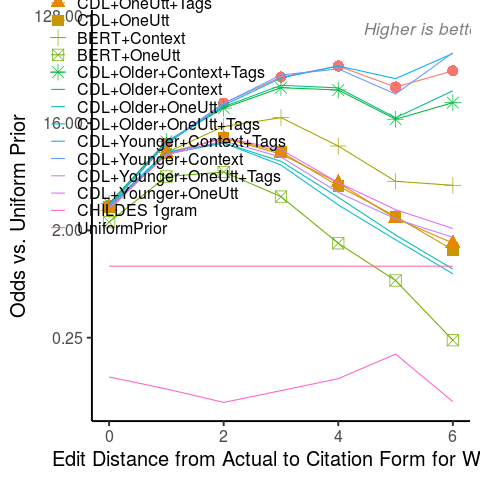

In [28]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.2, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic") + scale_y_continuous(trans='log2')
ggsave('figures/multiplier_by_edit_dstance_log_scale.pdf', height=6, width=8)    
print(p2)

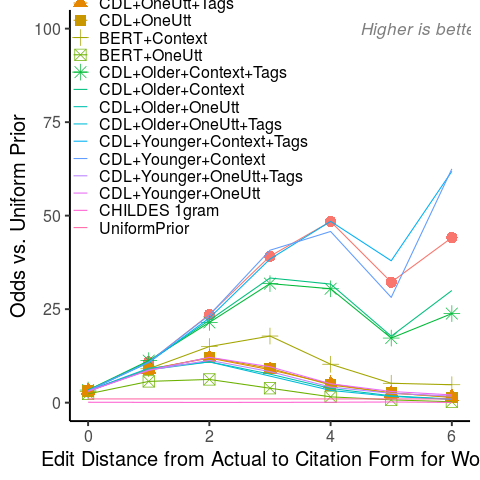

In [29]:
%%R
p2= ggplot(subset(surprisal_by_edit_distance, edit_distance <= 6)) + geom_point(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model), size=5) + theme_classic(base_size=20) + xlab( 
    'Edit Distance from Actual to Citation Form for Word') + ylab(
    'Odds vs. Uniform Prior') + geom_line(aes(x=edit_distance, 
    y = multiplier, color = model, shape=model))+ theme(legend.position=c(.3, .8), 
    legend.background=element_blank()) + scale_shape_discrete(name  ="Model" 
) + scale_color_discrete(name  ="Model") + annotate("text", label="Higher is better", 
    x=5.5, y=100, alpha=.5, size=6, fontface ="italic")
ggsave('figures/multiplier_by_edit_dstance_linear_scale.pdf', height=6, width=8)    
print(p2)

# 13 ROC for Completions 

In [30]:
%%R
library(plotROC)

In [31]:
%%R 
scores_across_time_short$set_binarized = 0
scores_across_time_short$set_binarized[scores_across_time_short$set == 'failure'] = 1
table(scores_across_time_short$set_binarized)

[1] 123510  38955


In [32]:
%%R
# Get AUC scores into these
unique(as.character(scores_across_time_short$model))

 [1] "BERT+OneUtt"              "BERT+Context"            
 [3] "CDL+OneUtt+Tags"          "CDL+OneUtt"              
 [5] "CDL+Context"              "CDL+Younger+OneUtt+Tags" 
 [7] "CDL+Younger+Context+Tags" "CDL+Younger+OneUtt"      
 [9] "CDL+Younger+Context"      "CDL+Older+OneUtt+Tags"   
[11] "CDL+Older+Context+Tags"   "CDL+Older+OneUtt"        
[13] "CDL+Older+Context"        "UniformPrior"            
[15] "CHILDES 1gram"           


In [33]:
%%R
library('pROC')
auc_by_model = do.call('rbind', lapply(unique(scores_across_time_short$model), 
      function(model_name){
    one_model = subset(scores_across_time_short, model == model_name)
    roc1 = roc(one_model$set_binarized, one_model$posterior_entropy)
    return(data.frame(model=model_name, auc = auc(roc1)))}))

scores_across_time_short = merge(scores_across_time_short, auc_by_model)


R[write to console]: Type 'citation("pROC")' for a citation.

R[write to console]: 
Attaching package: ‘pROC’


R[write to console]: The following object is masked from ‘package:plotROC’:

    ggroc


R[write to console]: The following objects are masked from ‘package:stats’:

    cov, smooth, var


R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls 

In [34]:
%%R
scores_across_time_short$model_with_auc = paste0(scores_across_time_short$model,' (AUC = ',
round(scores_across_time_short$auc, 2),')')

In [35]:
%%R
scores_across_time_short$model_with_auc[1:10]

 [1] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [3] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [5] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [7] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"
 [9] "BERT+Context (AUC = 0.84)" "BERT+Context (AUC = 0.84)"


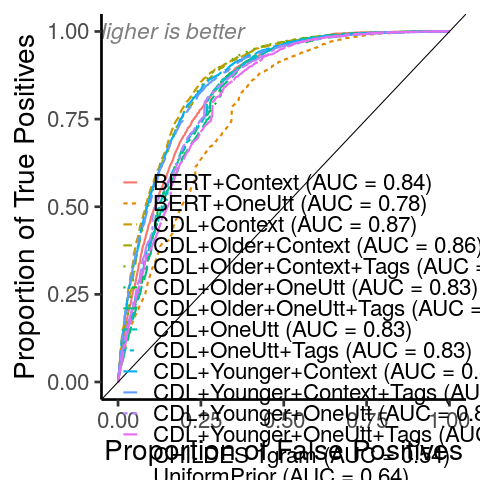

In [36]:
%%R 
p1 = ggplot(scores_across_time_short[,c('set_binarized', 'model_with_auc', 'posterior_entropy')], 
       aes(d=set_binarized, m=posterior_entropy, color=model_with_auc, linetype = model_with_auc)
) + theme_classic(base_size=28)+ geom_roc(n.cuts=0) + xlab('Proportion of False Positives'
) + ylab('Proportion of True Positives') + theme(legend.position=c(.67, .20),
legend.background = element_blank(), legend.title = element_blank()) + annotate("text",
label= "Higher is better", size=8, fontface="italic", x=.15, y=1, alpha =.5) + geom_abline(intercept=0, slope=1)
print(p1)
ggsave('figures/roc_2.pdf', height=12, width=12)    